<a href="https://colab.research.google.com/github/cdoyle78/Household-Utilities/blob/main/1031_Utilities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Seasonal Household Natural Gas Consumption


Late this fall we installed a radon mitigation system in our house. The system uses a fan connected to a sealed sump in order to drop the pressure below our foundation, reducing the amount of radon that enters the basement through foundation cracks, sump etc. 

As the weather has turned colder, it has become obvious that the system continually pumps out a significant amount of humid air. This had me wondering if it would have an impact on our heating bill. Either by drawing cooler air in around the basement, or possibly pulling warm air out of the basement.

In order to do this, I reviewed historical natural gas consumption from our bills. If we are seeing significant heat loss from the radon mitigation system, it should show up in our gas bill this winter. 

We have a dual heating system in our house with a forced air furnace, and an infloor hot water heating system powered by a boiler. The boiler also supplies our domestic hot water, but based on July and August average gas useage (where heating should be negligable) this is accounts for about 1.8 gigajoules (see appendix).

The house is a 2400 sqft two story with a developed basement (~1200 sqft). There are no other gas appliances in the house.

Monthly gas usage for heating is seasonal, and highly dependant on outdoor temperature. Variable weather means that comparing same month numbers is still to unpredictiable to predict monthly gas usage. By controlling for the average monthly temperature, we hope to be able compare monthy natural gas usage and determine if the radon mitigation system is having an impact.  

In [2]:
import pandas as pd 
import matplotlib as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

I've created a csv file by manually entering my monthly gas usage numbers, and pulled average monthly temperatures for Calgary from this site: https://calgary.weatherstats.ca/charts/temperature-monthly.html

In [5]:
#read in csv file containing monthly temperatures and gas consumption data and condition data

gas_df = pd.read_csv('Utilities.csv')

#meter reading dates are not completely consistent every month resulting in varying month lengths 
#Dividing metered consumption by days between readings, and mulitplying by 30.5 normalizes monthly consumption

gas_df['norm_gas'] = gas_df['Gigajoule']/gas_df['Days']*30.5

#turn 'Month' column into datetime series and set as index

gas_df['Month'] = pd.to_datetime(gas_df['Month'])
gas_df.set_index('Month', inplace = True)

In [6]:
#check the dataframe
gas_df.head()

,Start,End,Gigajoule,Days,Avg_Temp,norm_gas
Month,,,,,,
2013-05-01,5/5/2013,6/3/2013,5.81,29,11.9,6.110517
2013-06-01,6/4/2013,7/2/2013,2.89,28,13.8,3.148036
2013-07-01,7/3/2013,8/1/2013,1.91,29,16.2,2.008793
2013-08-01,8/2/2013,9/4/2013,0.96,33,17.4,0.887273
2013-09-01,9/5/2013,10/1/2013,2.93,26,14.1,3.437115


To start exploring the data, we'll use seaborn to plot the monthly gas consumption as well as monthly average temperature.

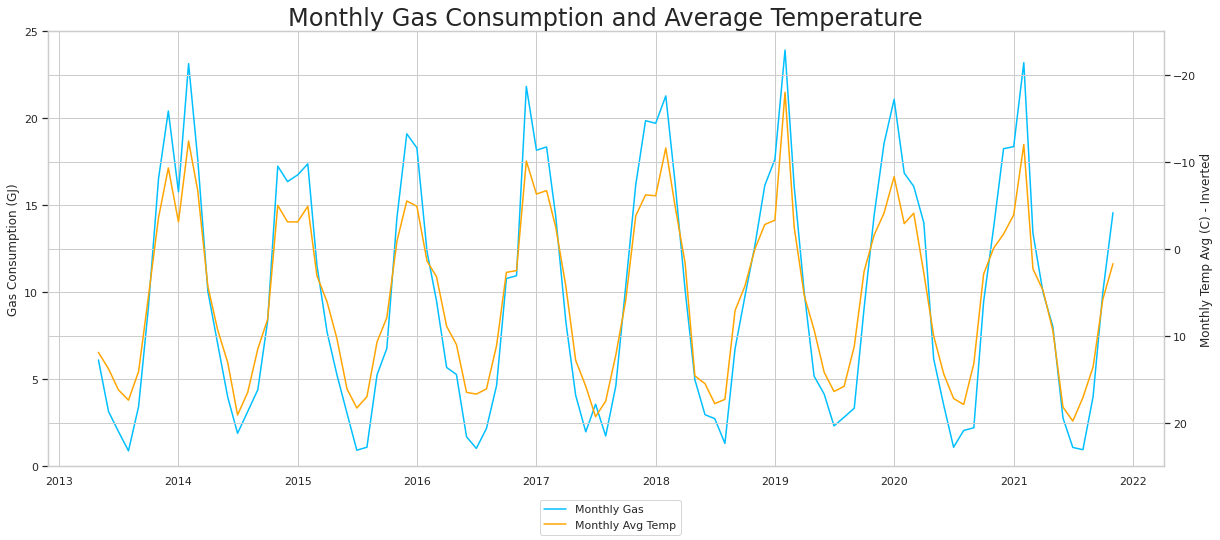

In [7]:
#plot monthly gas consumption and average temperature on seperate axis

sns.set(rc = {'figure.figsize':(20,8)})
sns.set_style("whitegrid")

ax = sns.lineplot(data = gas_df, x = 'Month', y = 'norm_gas', color = 'deepskyblue', label = 'Monthly Gas', legend = False)
ax2 = ax.twinx()
sns.lineplot(data = gas_df, x = 'Month', y = 'Avg_Temp', color = 'orange', ax = ax2, label = 'Monthly Avg Temp', legend = False)

ax.set(xlabel = None, ylabel = ('Gas Consumption (GJ)'))
ax2.set(ylabel = ('Monthly Temp Avg (C) - Inverted'))
ax.set(ylim = (0,25))
ax2.set(ylim = (25,-25))

plt.title('Monthly Gas Consumption and Average Temperature', size = 24)
ax.figure.legend(loc='lower center')

As expected, lower winter temperatures result in higher gas consumption, with cold snaps lining up with consumption spikes as in February 2019.

Next we'll look at the relationship between average monthly temperature and gas consumption with a couple of regression plots.

Text(0.5, 1.0, 'Monthly Gas Consumption vs Average Temperature')

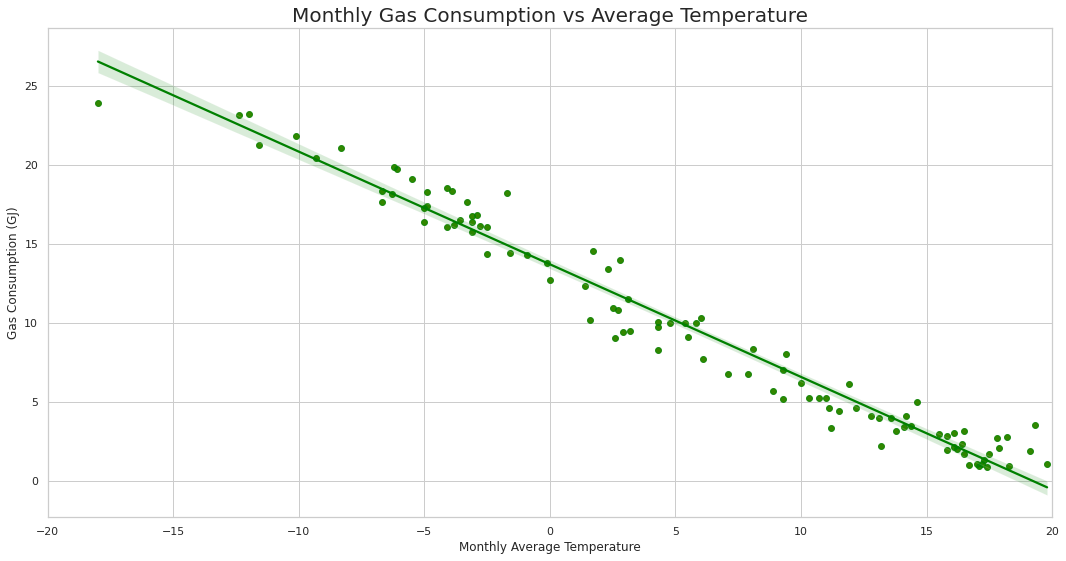

In [8]:
#seaborn scatter plot with a linear regression fit

sns.set(rc = {'figure.figsize':(18,9)})
sns.set_style("whitegrid")

ax3 = sns.scatterplot(data = gas_df, x = 'Avg_Temp', y = 'norm_gas', color = 'orange')
ax3 = sns.regplot(data = gas_df, x = 'Avg_Temp', y = 'norm_gas', scatter = 'False', color = 'green')
ax3.set(xlim = (-20,20),xlabel='Monthly Average Temperature', ylabel = 'Gas Consumption (GJ)')
plt.title('Monthly Gas Consumption vs Average Temperature', size = 20)

A simple linear regression fits the data fairly well. This surprises me somewhat, as I would expect greater heat loss as the delta bewteen interior and exterior temperature increases. The indoor thermometer generally stays fixed (if anything, turned up slightly during the colder months).

## What about polynomial fit?

[Text(0, 0.5, 'Monthly Gas Consumption (Gj)'),
 Text(0.5, 0, 'Monthly Average Temperature')]

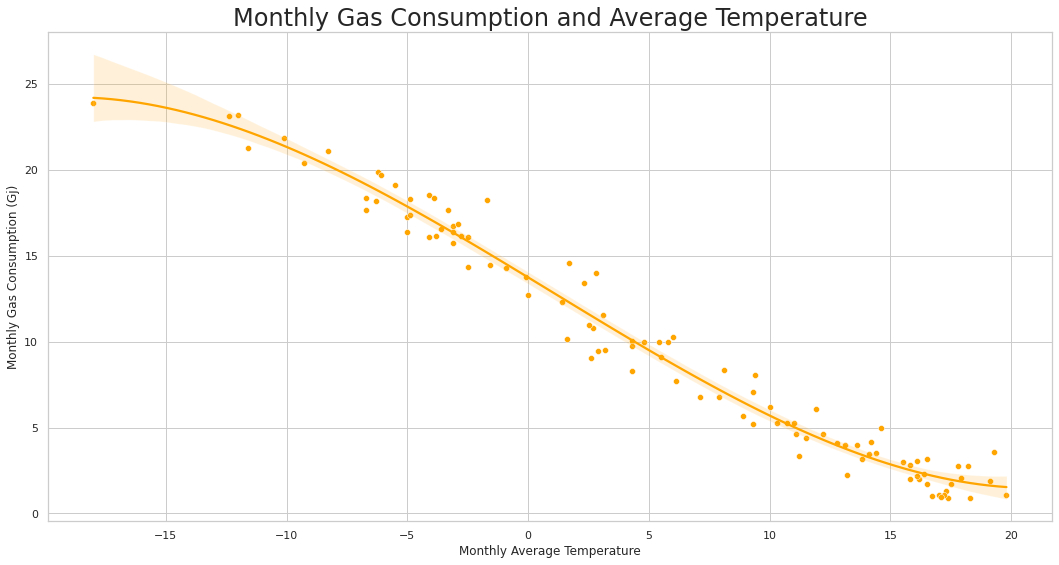

In [40]:
#plot a 3rd order polynomial fit to the data

ax3 = sns.scatterplot(data = gas_df, x = 'Avg_Temp', y = 'norm_gas', color = 'orange')
ax3 = sns.regplot(data = gas_df, x = 'Avg_Temp', y = 'norm_gas', order = 3, color = 'orange', scatter = False)
plt.title('Monthly Gas Consumption and Average Temperature', size = 24)
ax3.set(xlabel = 'Monthly Average Temperature', ylabel = 'Monthly Gas Consumption (Gj)')

Visually, this polynomial fit looks really good. It is possibly an over fit however, as the data is too sparse for average monthly temperatures below -15 degrees. Is it really possible the incremental gas burned per degree cooler moderates below average temperatures less than -15 degrees?

This seems very unlikely, but I have a couple ideas that could possibly explain it;


1.   Our house is orientated east-west on our lot with a large south exposure full of windows. As a result we receive a reasonable amount of passive solar heating in the winter. Is it possible that extremely cold months correlate with clearer condition and more passive solar heating occures? In the future I may look for a data source on hours of sunlight to see if it is a factor. 
2.   We have a dual heat system including a forced heat high-efficiancy furnace, and a hot water heat system powered by a boiler. Is it possible at very low temperatures, the hot water system picks up more of the load and is more efficient?




In [10]:
#Find date of low average temperature outlier

gas_df[gas_df.Avg_Temp == gas_df.Avg_Temp.min()]

,Start,End,Gigajoule,Days,Avg_Temp,norm_gas
Month,,,,,,
2019-02-01,1/28/2019,2/26/2019,22.75,29,-18.0,23.926724


Looking at the outlier date and checking our calendar, we were out of town for 9 days that month, which would reduce domestic hot water use somewhat. Our furnace also failed that month and was out for several hours. I doubt either of these factors would have had a large effect. 

Our radon mitigation system was installed on October 26th of 2021 so we only have one month of data to compare so far. Even correcting for temperature, there is enough variablility in the data that it will likely take several months to establish weather gas usage is trending higher, but let's have a look at November anyway.

In [11]:
gas_df[gas_df.index == '2021-11-01']

,Start,End,Gigajoule,Days,Avg_Temp,norm_gas
Month,,,,,,
2021-11-01,11/1/2021,11/26/2021,11.95,25,1.7,14.579


November saw an average temp of 1.7 degrees celsius, and natural gas consumption of 14.6 gigajoules.

Using Scikit Learn we can get the coefficients for linear regression model and determine the expected gas usage for Novembers temperature average.

In [13]:
#fit linear regresion model

x1 = np.array(gas_df.Avg_Temp).reshape(-1, 1)
y1 = np.array(gas_df.norm_gas).reshape(-1, 1)

reg = LinearRegression().fit(x1,y1)
reg.score(x1,y1)

0.965924761354276

Using the parameters from the regression, we can calculate the predicted gas usage for November 2021.

In [15]:
#get regression parameters and calculate expexted gas usage: yhat = (coefficient)x+(intercept)

print('Coefficent', reg.coef_)
print('Intercept', reg.intercept_)

yhat = 1.7*reg.coef_ + reg.intercept_
print('Predicted gas usage:', yhat[0])

Coefficent [[-0.7129971]]
Intercept [13.71931916]
Predicted gas usage: [12.50722409]


Scikit Learn also has a predict function that can be used:

In [16]:
reg.predict(np.array([[1.7]]))

array([[12.50722409]])

Linear regression predicts a November 2021 gas usage of 12.5 Gj vs the actual of 14.58 Gj. This is a relatively large error given the R2 value of 0.96. You can see from the plots above, this point is an outlier above the line. This could be an indication gas consumption, but it is still to early to tell.

## Polynomial Regression

The third order polynomial is slightly less accurate predicting a gas usage of 12.3 Gj. Despite the good visual fit, I still think it is likely an overfit, and the result of domestic water heating in the summer months, and sparse data on the extreme cold end. Regardless, the 3rd order fit is very linear through the majority of the winter data, and for now I will rely on it. If additional sub 15 degree average temperatures materialize, we can revisit it.

The calculations for the 3rd order polynomial fit can can be found in the appendix below in the meantime.

## Conclusion

Linear regression predicts does a good job predicting the household natural gas usage as a function of average temperature. The fit to historical data should help us determine if gas usage is higher than expected as a result of the radon mitigation system. 

The first month data post installation seems to point to higher gas consumption, but additional data will be needed to draw a firm conclusion.

## Appendix

1. Averaging the gas usage for July and August from every year should give a good idea about how much gas is used for domestic water heat.

In [ ]:
gas_df[pd.DatetimeIndex(gas_df.index).month.isin([7,8])].norm_gas.mean()

1.8259275959751493

2. Currently, seaborn will not output the coefficints for its regplots. Using Scikit Learn however, we can calculate the coefficients for the 3rd order polynomial fit.

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

x1 = np.array(gas_df.Avg_Temp).reshape(-1, 1)
y1 = np.array(gas_df.norm_gas).reshape(-1, 1)

poly = PolynomialFeatures(degree=3)
x1_poly = poly.fit_transform(x1)

LR = linear_model.LinearRegression()
y1_ = LR.fit(x1_poly,y1)
# The coefficients
print ('Coefficients: ', LR.coef_)
print ('Intercept: ', LR.intercept_)

Coefficients:  [[ 0.00000000e+00 -8.54253295e-01 -2.23986631e-03  7.19012328e-04]]
Intercept:  [13.74702909]


[Text(0, 0.5, 'Monthly Gas Consumption (Gj)'),
 Text(0.5, 0, 'Monthly Average Temperature')]

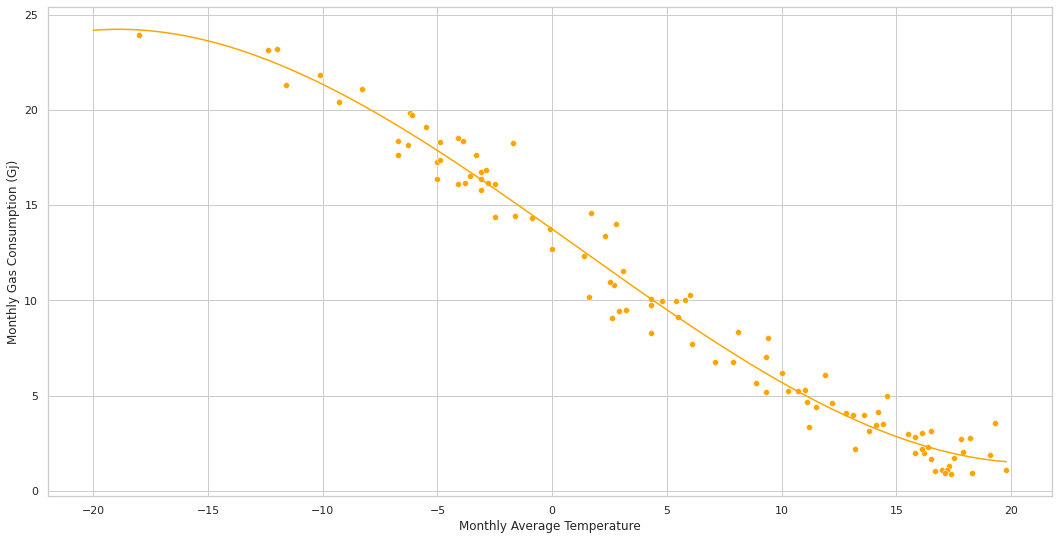

In [39]:
#Plot the data again with the 3rd order fit from sklearn.

ax4 = sns.scatterplot(data = gas_df, x = 'Avg_Temp', y = 'norm_gas', color = 'orange')

#3rd order polynomial fit calculated with sklearn

XX = np.arange(-20.0, 20.0, 0.2)
yy = LR.intercept_[0]+ LR.coef_[0][1]*XX+ LR.coef_[0][2]*np.power(XX, 2)+LR.coef_[0][3]*np.power(XX, 3)
plt.plot(XX, yy, '-r', color = 'orange' )
ax4.set(xlabel = 'Monthly Average Temperature', ylabel = 'Monthly Gas Consumption (Gj)')

Predicting the November 2021 gas consumption from the polynomial fit gives us 12.29 Gj.

In [32]:
x_nov21 = 1.7 #November 2021 average temp
y_hat_poly = LR.intercept_[0]+ LR.coef_[0][1]*x_nov21+ LR.coef_[0][2]*np.power(x_nov21, 2)+LR.coef_[0][3]*np.power(x_nov21, 3)
y_hat_poly

12.29185777915001